testing LeNet-5 as seen [here](https://www.pugetsystems.com/labs/hpc/The-Best-Way-to-Install-TensorFlow-with-GPU-Support-on-Windows-10-Without-Installing-CUDA-1187/#create-a-python-virtual-environment-for-tensorflow-using-conda).

In [1]:
import numpy as np
import time
# keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten,  MaxPooling2D, Conv2D
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
# scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# data processing pipeline - see .py file
from data_processing import processing_pipeline
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve

Using TensorFlow backend.


In [2]:
# getting X and y - old data
f1 = './data/sample_data/Farah_Pot_5cm_sq_15um.txt'
f2 = './data/sample_data/Grant_Pot_5cm_sq_15um.txt'
files = [f1,f2]

patch_size = 60
X, y = processing_pipeline(files, patch_size)
print(f"There are {len(y)} patches.")

There are 5820 patches.


In [3]:
X.shape

(2064, 100, 100)

In [3]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y)
# reshaping for Keras
X_train = X_train.reshape(*X_train.shape,1)
X_test = X_test.reshape(*X_test.shape,1)
# getting y arrays for Keras
n_classes = len(files)
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [4]:
# getting some parameters
input_shape = X_train.shape[1:]

In [12]:
# building LeNet without augmentation
# add a first layer to get see what it's doing
model = Sequential()
model.add(Conv2D(2, kernel_size=(7,7), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape) )
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())          
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

In [13]:
# compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# saving tensorboard
tensor_board = TensorBoard('./logs/LeNet-painterID-2')

## Scaling 

In [7]:
from sklearn.preprocessing import RobustScaler

In [8]:
def scale_data(X_train, X_test, scaler):
    s = scaler
    X_train = s.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)
    X_test = s.transform(X_test.reshape(-1,1)).reshape(X_test.shape)
    
    return X_train, X_test

In [9]:
X_train, X_test = scale_data(X_train, X_test, RobustScaler())

## First fit

In [14]:
# parameters for fit
batch_size = 32
epochs = 15

# fitting the model
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(X_test,y_test), callbacks=[tensor_board])

Train on 4365 samples, validate on 1455 samples
Epoch 1/15
4365/4365 [==============================] - 3s 744us/step - loss: 0.6375 - acc: 0.6527 - val_loss: 0.6329 - val_acc: 0.6756
Epoch 2/15
4365/4365 [==============================] - 3s 683us/step - loss: 0.5553 - acc: 0.7249 - val_loss: 0.6004 - val_acc: 0.7203
Epoch 3/15
4365/4365 [==============================] - 3s 685us/step - loss: 0.5091 - acc: 0.7485 - val_loss: 0.6018 - val_acc: 0.6942
Epoch 4/15
4365/4365 [==============================] - 3s 690us/step - loss: 0.4706 - acc: 0.7785 - val_loss: 0.5900 - val_acc: 0.7375
Epoch 5/15
4365/4365 [==============================] - 3s 774us/step - loss: 0.4337 - acc: 0.8018 - val_loss: 0.6128 - val_acc: 0.7292
Epoch 6/15
4365/4365 [==============================] - 3s 755us/step - loss: 0.3641 - acc: 0.8351 - val_loss: 0.6524 - val_acc: 0.7265
Epoch 7/15
4365/4365 [==============================] - 3s 694us/step - loss: 0.2995 - acc: 0.8722 - val_loss: 0.6587 - val_acc: 0.7354


## Saving the model

In [20]:
# timestamp = str(int(time.time()*1000000))[0:-1]
# model.save(f'./models/LeNet-5-mod-{timestamp}.h5')
# model.save(f'./models/LeNet-5-mod-v1.h5')

## Looking at the filters

In [15]:
def get_filter(layer,index):
    return model.get_weights()[layer][:,:,0,index]

def apply_filter(X, sample, weights):
    return convolve(X[sample,:,:,0], weights)

def viz_filtered_sample(X, sample, weights, ax=None):
    colv_samp = convolve(X[sample,:,:,0], weights)
    return sns.heatmap(colv_samp, cmap=cmap, cbar = False, ax=ax,
                      xticklabels=False,
                      yticklabels=False)

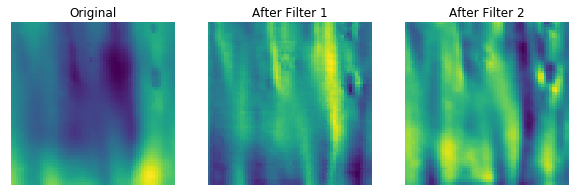

In [18]:
# colormap and sample
cmap='viridis'
sample_idx = np.random.randint(0,len(X_train),1)[0]

fig, axes = plt.subplots(1,3,figsize = (10,3))

viz_filtered_sample(X_train, sample_idx, np.identity(1), axes[0])
axes[0].set_title('Original')

weigths = get_filter(0,0)
viz_filtered_sample(X_train, sample_idx, weigths, axes[1])
axes[1].set_title('After Filter 1')

weigths = get_filter(0,1)
viz_filtered_sample(X_train, sample_idx, weigths, axes[2])
axes[2].set_title('After Filter 2')

timestamp = str(int(time.time()*1000000))[0:-1]
# plt.savefig('./figures/{0}_by_{0}_input_{1}_by_{1}_filter_{2}.png'.format(patch_size, 7, timestamp),
#            bbox_inches='tight', dpi=200)

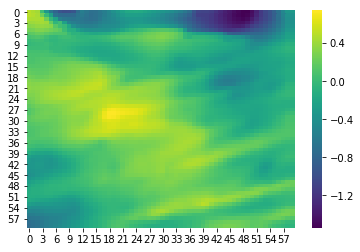

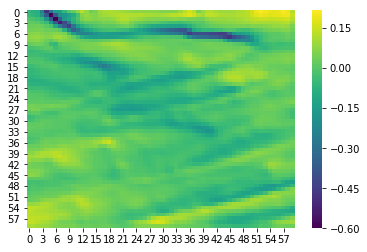

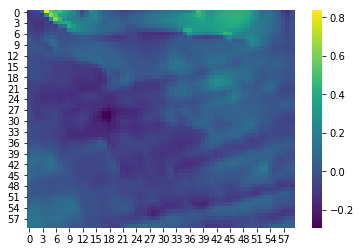

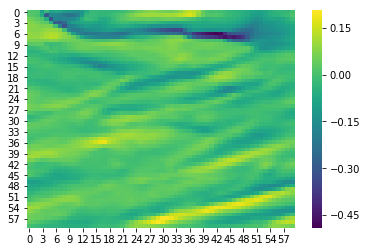

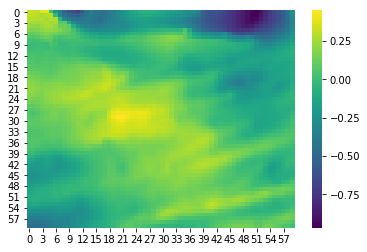

In [19]:
for i in range(5):
    output = apply_filter(X_train, 0, weights = get_filter(2,i))
    sns.heatmap(output,  cmap=cmap)
    plt.show()

## With augmentation

In [12]:
# data augmentation
datagen = ImageDataGenerator(
    #featurewise_center = True,
    #featurewise_std_normalization=True)
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True)
# fit it
datagen.fit(X_train)

In [ ]:
# parameters for fit
batch_size = 32
epochs = 15

# fit model with data augmentation
model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch= len(X_train)//batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4)